In [251]:
import torch
from torch import nn

import torchvision
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

In [252]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# load data

In [253]:
train_data = torchvision.datasets.MNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

test_data = torchvision.datasets.MNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)


Files already downloaded
Files already downloaded


In [254]:
train_data.train_data.shape, test_data.test_data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

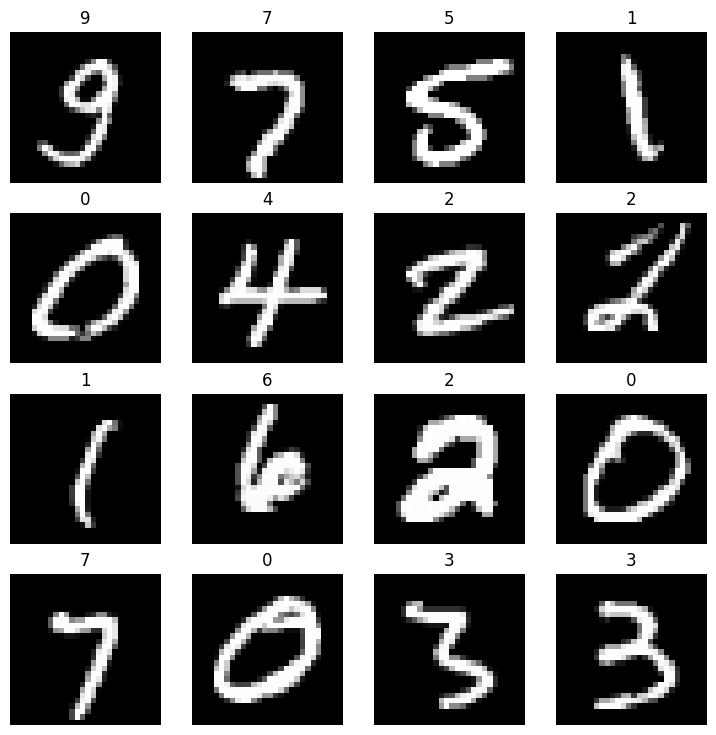

In [255]:
## Plot some images

fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(label.item())
    plt.axis(False)

In [256]:
# Prepare dataloader

from torch.utils.data import DataLoader

batch_size = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
)
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=True,
)

In [257]:
len(test_dataloader)

313

In [258]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

# Build Model

In [259]:
## build model

flatten_model = nn.Flatten()

x = train_features_batch[0]
output = flatten_model(x)
x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [260]:
class MNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [261]:
class MNISTConvModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_stack_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv_stack_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_stack_1(x)
        x = self.conv_stack_2(x)
        x = self.classifier(x)
        return x

In [262]:
num_classes = 10

In [263]:
model_0 = MNISTModel(input_shape=28 * 28, hidden_units=10, output_shape=num_classes).to(
    device
)
model_1 = MNISTConvModel(input_shape=1, hidden_units=10, output_shape=num_classes).to(
    device
)

model_0, model_1

(MNISTModel(
   (layer_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=10, bias=True)
     (2): ReLU()
     (3): Linear(in_features=10, out_features=10, bias=True)
     (4): ReLU()
   )
 ),
 MNISTConvModel(
   (conv_stack_1): Sequential(
     (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (conv_stack_2): Sequential(
     (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (classifier): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=490, out_features

In [264]:
# send dummy forward pass

dummy_x = torch.rand([1, 1, 28, 28])
model_0.eval()
model_1.eval()
with torch.inference_mode():
    dummy_y = model_0(dummy_x)
    dummy_y_2 = model_1(dummy_x)
    
dummy_y.shape, dummy_y_2.shape

(torch.Size([1, 10]), torch.Size([1, 10]))

# Train Data

In [265]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [266]:
def train_step(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
):
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(data_loader):
        model.train()

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"train_loss {train_loss:.4f} train_acc {train_acc:.4f}%")

In [267]:
def test_step(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    accuracy_fn,
):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            test_pred = model(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    print(f"test_loss {test_loss:.4f} test_acc {test_acc:.4f}%")

In [268]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1,
)

start_time = timer()
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"epoch: {epoch}")
    train_step(
        model=model_0,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
    )
    test_step(
        model=model_0,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
    )

end_time = timer()
total_time = end_time - start_time
print(f"total time: {total_time}")

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0
train_loss 0.8457 train_acc 72.0050%


 33%|███▎      | 1/3 [00:11<00:23, 11.53s/it]

test_loss 0.6891 test_acc 75.8187%
epoch: 1
train_loss 0.6329 train_acc 78.4067%


 67%|██████▋   | 2/3 [00:22<00:11, 11.05s/it]

test_loss 0.5107 test_acc 83.0871%
epoch: 2
train_loss 0.4922 train_acc 83.3683%


100%|██████████| 3/3 [00:31<00:00, 10.62s/it]

test_loss 0.4838 test_acc 83.5064%
total time: 31.85294679800063


# Test model

In [269]:
def eval_model(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc,
    }


model_results = eval_model(
    model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_results

{'model_name': 'MNISTModel',
 'model_loss': 0.4834654629230499,
 'model_acc': 83.52635782747603}

# Test model 2

In [270]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params=model_1.parameters(),
    lr=0.1,
)

start_time = timer()
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"epoch: {epoch}")
    train_step(
        model=model_1,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
    )
    test_step(
        model=model_1,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
    )

end_time = timer()
total_time = end_time - start_time
print(f"total time: {total_time}")


  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0
train_loss 0.3373 train_acc 88.9150%


 33%|███▎      | 1/3 [00:36<01:12, 36.49s/it]

test_loss 0.0773 test_acc 97.5140%
epoch: 1
train_loss 0.0755 train_acc 97.7067%


 67%|██████▋   | 2/3 [01:11<00:35, 35.71s/it]

test_loss 0.0520 test_acc 98.4125%
epoch: 2
train_loss 0.0584 train_acc 98.1983%


100%|██████████| 3/3 [01:45<00:00, 35.12s/it]

test_loss 0.0495 test_acc 98.3227%
total time: 105.36486656000125


In [272]:
model_1_results = eval_model(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
)
model_1_results

{'model_name': 'MNISTConvModel',
 'model_loss': 0.04931037873029709,
 'model_acc': 98.3326677316294}

# Test Predictions

In [356]:
def make_predictions(model: nn.Module, data: list):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logits = model(sample)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

(-0.5, 27.5, 27.5, -0.5)

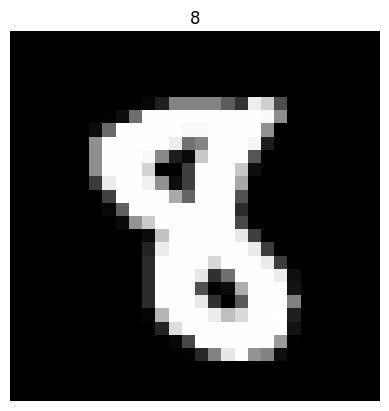

In [355]:
import random

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label.item())

plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(test_labels[0])
plt.axis(False)

In [331]:
test_samples[1].shape

torch.Size([1, 28, 28])

In [332]:
logits = make_predictions(model_1, test_samples[:3])
logits


tensor([[2.1462e-03, 9.6480e-01, 5.4648e-04, 3.0321e-04, 3.2428e-03, 3.7743e-04,
         1.7738e-03, 8.6464e-03, 1.4834e-02, 3.3260e-03],
        [9.0650e-09, 1.1390e-10, 2.3223e-10, 1.8161e-04, 9.3728e-08, 9.9662e-01,
         6.6091e-07, 2.0615e-09, 5.7016e-06, 3.1923e-03],
        [1.4215e-03, 9.9438e-01, 1.8901e-03, 5.6727e-05, 5.2011e-04, 2.5124e-05,
         1.9038e-04, 2.5054e-04, 1.2079e-03, 5.4027e-05]])

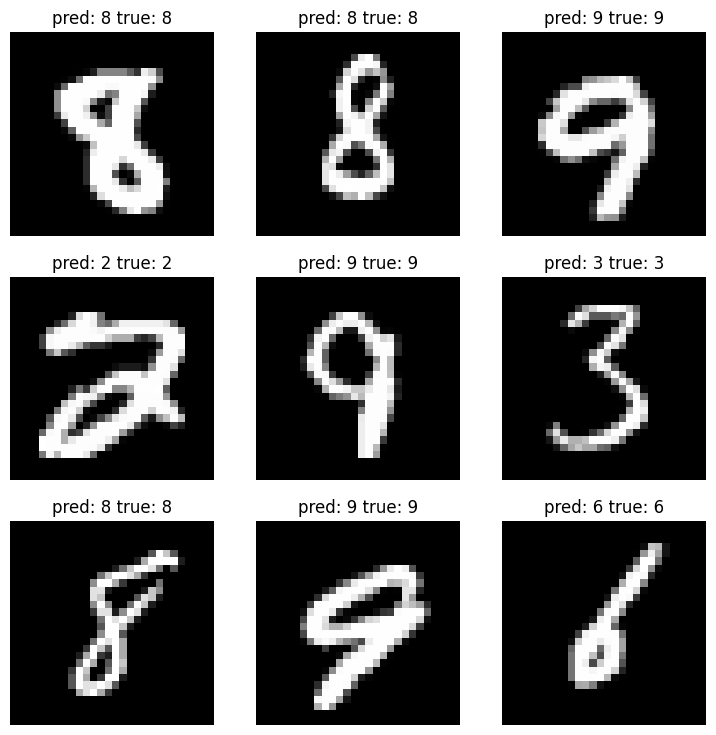

In [357]:
def plot_some_preds(model: nn.Module, test_samples: list, test_labels: list):
    fig = plt.figure(figsize=(9,9))
    preds = make_predictions(model, test_samples)
    for i, (sample, label, pred) in enumerate(zip(test_samples, test_labels, preds)):
        fig.add_subplot(3, 3, i+1)
        plt.imshow(sample.squeeze(), cmap="gray")
        plt.title(f"pred: {pred.argmax().item()} true: {label}")
        plt.axis(False)
plot_some_preds(model_1, test_samples, test_labels)

In [382]:
from tqdm.auto import tqdm

y_preds = []
y_labels = []
model_1.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_1(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
    y_labels.append(y.cpu())
y_pred_tensor = torch.cat(y_preds)
y_labels_tensor = torch.cat(y_labels)
y_pred_tensor.shape, y_labels_tensor.shape

Making predictions: 100%|██████████| 313/313 [00:02<00:00, 115.25it/s]


(torch.Size([10000]), torch.Size([10000]))

In [389]:
(y_pred_tensor == y_labels_tensor).sum().item() / len(y_labels_tensor)

0.9833

<Axes: >

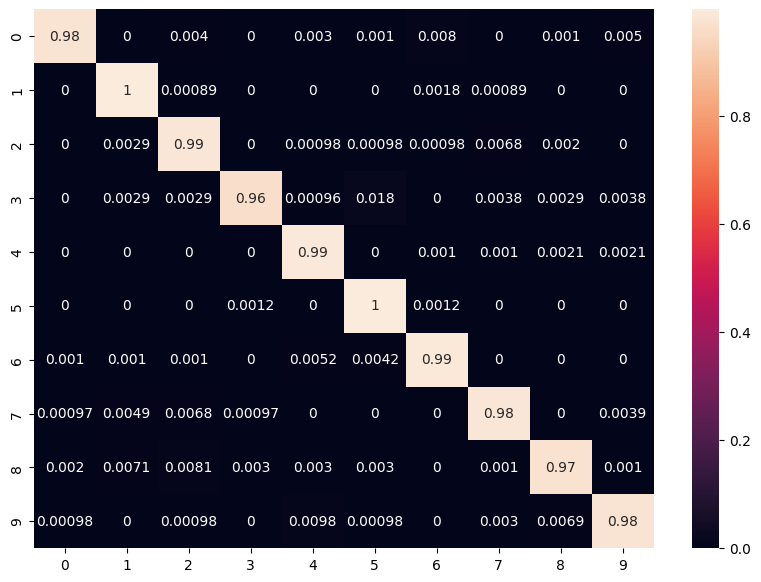

In [391]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

cf_matrix = confusion_matrix(y_pred_tensor, y_labels_tensor)

classes = list(range(num_classes))
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)